<a href="https://colab.research.google.com/github/partha1189/machine_learning/blob/master/LSTMTime_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1),input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 100.0)
])

In [6]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
46/46 [==============================] - 0s 7ms/step - loss: 39.9320 - mae: 40.4317
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 38.0278 - mae: 38.5276
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 35.7150 - mae: 36.2147
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 32.9225 - mae: 33.4218
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 29.5583 - mae: 30.0579
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 25.1841 - mae: 25.6831
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: 18.8951 - mae: 19.3924
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 13.8833 - mae: 14.3765
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: 12.8407 - mae: 13.3350
Epoch 10/100
46/46 [==============================] - 0s 6ms/step - loss: 12.2981 - mae: 12.7923
Epoch 11/100
46/46 [===================

(1e-08, 0.0001, 0.0, 30.0)

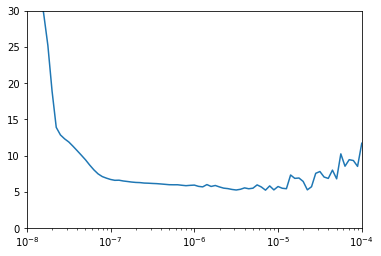

In [7]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1),input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

In [9]:
forecast = [] 
results = []

In [10]:
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))


In [11]:
forecast

[array([[41.40637]], dtype=float32),
 array([[40.84934]], dtype=float32),
 array([[47.436226]], dtype=float32),
 array([[43.34935]], dtype=float32),
 array([[42.816925]], dtype=float32),
 array([[41.337013]], dtype=float32),
 array([[41.537178]], dtype=float32),
 array([[41.98103]], dtype=float32),
 array([[40.85475]], dtype=float32),
 array([[42.093037]], dtype=float32),
 array([[41.039032]], dtype=float32),
 array([[41.02441]], dtype=float32),
 array([[40.798233]], dtype=float32),
 array([[46.352463]], dtype=float32),
 array([[42.34632]], dtype=float32),
 array([[41.09728]], dtype=float32),
 array([[42.25343]], dtype=float32),
 array([[40.783398]], dtype=float32),
 array([[40.88307]], dtype=float32),
 array([[39.997524]], dtype=float32),
 array([[39.972706]], dtype=float32),
 array([[40.286076]], dtype=float32),
 array([[40.873783]], dtype=float32),
 array([[40.450542]], dtype=float32),
 array([[40.23319]], dtype=float32),
 array([[39.956116]], dtype=float32),
 array([[39.52886]], dt

In [13]:
len(forecast)

1441

In [14]:
split_time

1000

In [15]:
forecast = forecast[split_time - window_size:]

In [16]:
len(forecast)

461

In [17]:
window_size

20

In [18]:
 results = np.array(forecast)

In [19]:
results

array([[[68.40883 ]],

       [[69.4659  ]],

       [[69.8978  ]],

       [[72.83558 ]],

       [[72.270515]],

       [[67.87677 ]],

       [[70.04075 ]],

       [[70.04529 ]],

       [[70.57119 ]],

       [[71.47189 ]],

       [[72.365105]],

       [[69.874725]],

       [[71.17041 ]],

       [[72.019005]],

       [[72.42293 ]],

       [[72.15021 ]],

       [[73.21754 ]],

       [[74.55536 ]],

       [[69.518135]],

       [[67.71274 ]],

       [[66.73305 ]],

       [[67.6161  ]],

       [[68.4726  ]],

       [[66.8124  ]],

       [[67.685776]],

       [[69.14322 ]],

       [[74.931305]],

       [[76.18207 ]],

       [[73.904106]],

       [[71.484955]],

       [[71.89196 ]],

       [[67.30521 ]],

       [[68.39211 ]],

       [[60.15854 ]],

       [[67.15469 ]],

       [[67.67849 ]],

       [[67.228264]],

       [[69.36996 ]],

       [[67.48785 ]],

       [[62.349762]],

       [[66.78009 ]],

       [[67.857285]],

       [[71.5919  ]],

       [[73

In [20]:
results = results[:, 0, 0]

In [21]:
results

array([68.40883 , 69.4659  , 69.8978  , 72.83558 , 72.270515, 67.87677 ,
       70.04075 , 70.04529 , 70.57119 , 71.47189 , 72.365105, 69.874725,
       71.17041 , 72.019005, 72.42293 , 72.15021 , 73.21754 , 74.55536 ,
       69.518135, 67.71274 , 66.73305 , 67.6161  , 68.4726  , 66.8124  ,
       67.685776, 69.14322 , 74.931305, 76.18207 , 73.904106, 71.484955,
       71.89196 , 67.30521 , 68.39211 , 60.15854 , 67.15469 , 67.67849 ,
       67.228264, 69.36996 , 67.48785 , 62.349762, 66.78009 , 67.857285,
       71.5919  , 73.24294 , 72.5825  , 72.39281 , 70.44066 , 70.67647 ,
       72.40322 , 65.72681 , 70.65808 , 73.533775, 73.168274, 72.23866 ,
       71.376656, 72.4146  , 69.09323 , 66.75547 , 67.66938 , 69.31053 ,
       72.72949 , 70.72203 , 71.65879 , 61.519424, 70.19957 , 66.102005,
       68.4342  , 63.587074, 62.02525 , 67.19512 , 68.50331 , 69.5685  ,
       69.76713 , 70.47317 , 70.599365, 66.294334, 69.780045, 70.95101 ,
       64.80704 , 66.329994, 68.690254, 72.47255 , 

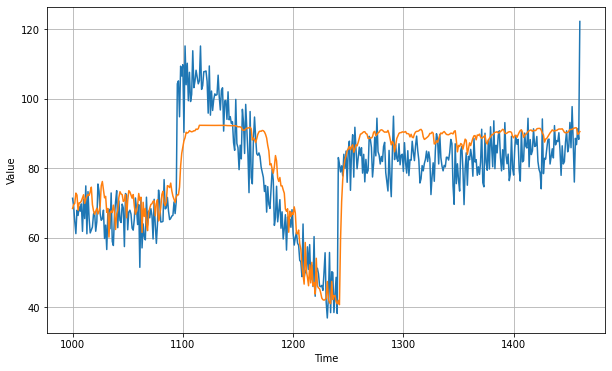

In [22]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.260268

<Figure size 432x288 with 0 Axes>

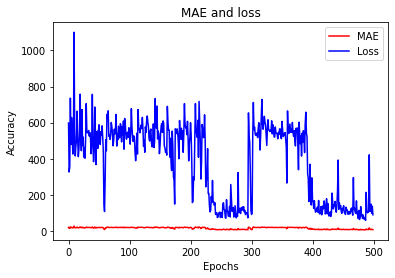

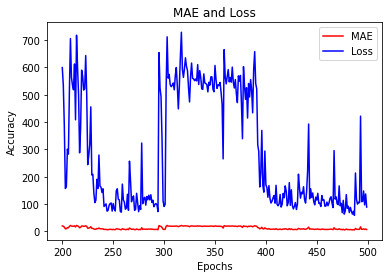

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image as mpimg

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [25]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 13ms/step - loss: 165.4724
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 79.0748
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 76.3405
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 62.1724
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 60.9039
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 60.5475
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 59.7192
Epoch 8/100
31/31 [==============================] - 0s 12ms/step - loss: 57.7761
Epoch 9/100
31/31 [==============================] - 0s 12ms/step - loss: 53.2666
Epoch 10/100
31/31 [==============================] - 0s 13ms/step - loss: 51.7275
Epoch 11/100
31/31 [==============================] - 0s 12ms/step - loss: 57.6852
Epoch 12/100
31/31 [==============================] - 0s 13ms/step - loss: 59.2878
Epoch 13/100